#### Voronoi Binning

In [2]:
import json
from pycasso2.resampling import ReSamplingMatrixNonUniform
from voronoi_utils import VorbinUtils

In [3]:
with open("sci_files_object_mapping.json", "r") as f:
    sci_files_object_mapping = json.load(f)

redux/gsn069_pca_combined_spectra_ext_3D.fits
Good bins: 20
Share of good bins: 0.25


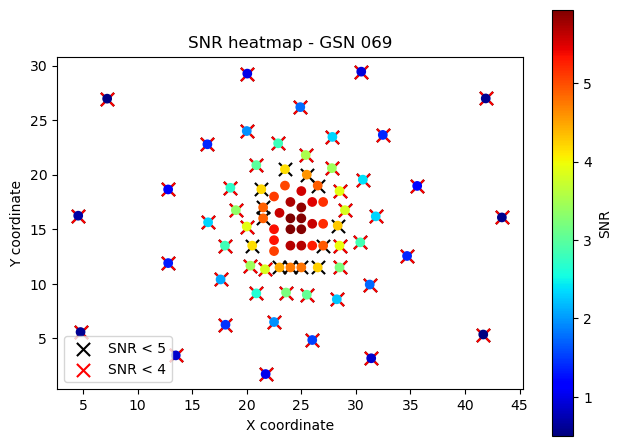

In [27]:
# GSN 069
ini_w = 5655
fin_w = 5745
target_sn = 7

object_name = list(sci_files_object_mapping.keys())[1]
name = object_name.replace(" ", "").lower()
filename = f"redux/{name}_pca_combined_spectra_ext_3D.fits"
print(filename)
vor = VorbinUtils(filename, ini_w, fin_w)
vor.voronoi_bin(target_sn)
vor.calculate_true_snr(plot=True)

Good bins: 0
Share of good bins: 0.0


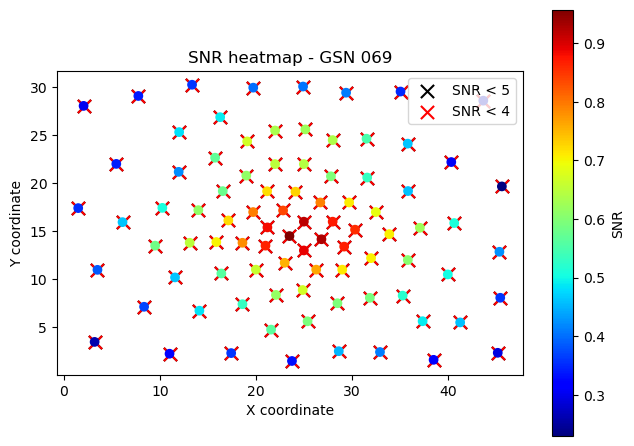

In [28]:
# eRO-QPE2

ini_w = 5050
fin_w = 5200
target_sn = 2

object_name = list(sci_files_object_mapping.keys())[0]
name = object_name.replace(" ", "").lower()
filename = f"redux/{name}_pca_combined_spectra_ext_3D.fits"
vor = VorbinUtils(filename, ini_w, fin_w)
vor.voronoi_bin(target_sn)
vor.calculate_true_snr(plot=True)

#### Resampling

In [8]:
def resampling(res_lambda_min, res_lambda_max, rfwave, rfflux, rferr, qual):
    lresamp = np.arange(res_lambda_min, res_lambda_max, 1)
    matrix = ReSamplingMatrixNonUniform(rfwave, lresamp)
    fresamp = np.dot(matrix, rfflux)
    errresamp = np.dot(matrix, rferr)
    qualresamp = np.dot(matrix, qual)

    for i in range(len(qualresamp)):
        if lresamp[i] < min(rfwave):
            qualresamp[i] = 2

        elif lresamp[i] > max(rfwave):
            qualresamp[i] = 2

        if qualresamp[i] > 0:
            qualresamp[i] = 2

    return lresamp, fresamp, errresamp, qualresamp

In [9]:
lambda_min = int(np.min(wavelength))
lambda_max = int(np.max(wavelength))
res_wavelenght, res_signal, res_var, res_quality_map = resampling(
    res_lambda_min=lambda_min,
    res_lambda_max=lambda_max,
    rfwave=wavelength,
    rfflux=binned_data[0]["signal"],
    rferr=binned_data[0]["var"],
    qual=binned_data[0]["quality_map"],
)

resampled_data = {}
for bin_id, bin_data in enumerate(binned_data.values()):
    res_wavelenght, res_signal, res_var, res_quality_map = resampling(
        res_lambda_min=lambda_min,
        res_lambda_max=lambda_max,
        rfwave=wavelength,
        rfflux=binned_data[bin_id]["signal"],
        rferr=binned_data[bin_id]["var"],
        qual=binned_data[bin_id]["quality_map"],
    )
    resampled_data[bin_id] = {}
    resampled_data[bin_id]["wavelength"] = res_wavelenght
    resampled_data[bin_id]["signal"] = res_signal
    resampled_data[bin_id]["var"] = res_var
    resampled_data[bin_id]["quality_map"] = res_quality_map

#### Create input files

In [10]:
# Create obs input files
for bin_id, bin_data in enumerate(resampled_data.values()):
    input_data = np.stack(
        [
            bin_data["wavelength"],
            bin_data["signal"],
            np.sqrt(bin_data["var"]),
            bin_data["quality_map"],
        ],
        axis=1,
    )
    np.savetxt(
        f"redux/starlight_synthesis/gsn069/obs_dir/{bin_id}",
        input_data,
        fmt=["%f", "%f", "%f", "%d"],
    )

/tmp/ipykernel_12670/3582690033.py:7: RuntimeWarning: invalid value encountered in sqrt
  np.sqrt(bin_data["var"]),


In [13]:
# Create mask input files
maskfilename = "MaskEmissionAbsortionGSN069"

with open("redux/gsn069_masks.json", "r") as f:
    masks_json = json.load(f)

window_range = 8
masks_json["emission_centers"] = np.round(masks_json["emission_centers"])
masks_json["emission_windows"] = [
    [emiss_center - window_range, emiss_center + window_range]
    for emiss_center in masks_json["emission_centers"]
]


all_masks = masks_json["emission_windows"]
all_masks.extend(masks_json["absortion_windows"])
nmasks = len(all_masks)

with open(f"redux/starlight_synthesis/{maskfilename}", "w") as file:
    file.write(str(nmasks) + "\n")
    for window in all_masks:
        file.write(f"{window[0]} {window[1]} 0 \n")